# Deep Learning Assignment 3 - Part 1

Student 1: Raneem Ibraheem + 212920896

Student 2: Aseel Nahhas + 212245096

# Import required libraries

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the dataset and showcase a few samples

In [19]:
songs_df = pd.read_csv('Songs.csv')
songs_df.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


# Printing the artists names with the number of associated songs

In [20]:
artist_song_count = songs_df['Artist'].value_counts()
print(artist_song_count)

Artist
Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: count, dtype: int64


# Printing the dataset size and the amount of songs

In [21]:
dataset_size = songs_df.shape
total_songs = len(songs_df)
print(f"Dataset size (rows, columns): {dataset_size}")
print(f"Total number of songs: {total_songs}")

Dataset size (rows, columns): (745, 3)
Total number of songs: 745


# Printing the average number of chars and average number of words per song

In [22]:
average_characters = songs_df['Lyrics'].apply(len).mean()
average_words = songs_df['Lyrics'].apply(lambda x: len(x.split())).mean()

print(f"Average number of characters per song: {average_characters}")
print(f"Average number of words per song: {average_words}")

Average number of characters per song: 1403.3476510067114
Average number of words per song: 276.26040268456376


# Visualize the words using word cloud and print the most used words

Top 3 most used words: [('the', 7458), ('I', 6719), ('you', 5475)]


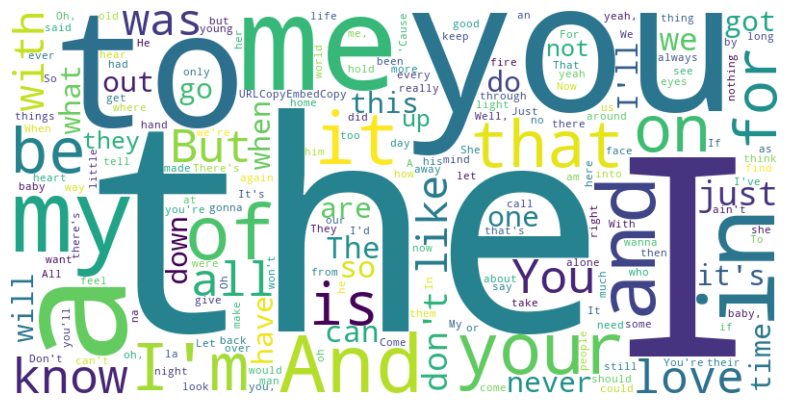

In [23]:
all_lyrics = ' '.join(songs_df['Lyrics'])
word_counts = Counter(all_lyrics.split())
top_3_words = word_counts.most_common(3)
print("Top 3 most used words:", top_3_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing the data and encoding it

In [24]:
corpus = songs_df['Lyrics'].tolist()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

cleaned_corpus = [clean_text(lyrics) for lyrics in corpus]

all_text = ' '.join(cleaned_corpus)

chars = sorted(list(set(all_text)))

char2idx = {char: i+1 for i, char in enumerate(chars)}
idx2char = {i+1: char for i, char in enumerate(chars)}
vocab_size = len(chars) + 1

tokenized_corpus = []
for lyrics in cleaned_corpus:
    tokens = [char2idx[char] for char in lyrics if char in char2idx]
    tokenized_corpus.append(torch.tensor(tokens, dtype=torch.long))

input_sequences = []
target_sequences = []
for tokens in tokenized_corpus:
    if len(tokens) < 2:
        continue
    input_sequences.append(tokens[:-1])
    target_sequences.append(tokens[1:])

input_padded = torch.nn.utils.rnn.pad_sequence(input_sequences, batch_first=True, padding_value=0)
target_padded = torch.nn.utils.rnn.pad_sequence(target_sequences, batch_first=True, padding_value=0)

In [25]:
class LyricsLSTM_LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super(LyricsLSTM_LM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        output = self.fc(lstm_out)
        return output, hidden

embedding_dim = 128
hidden_dim = 256
n_layers = 2

model = LyricsLSTM_LM(vocab_size, embedding_dim, hidden_dim, n_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
batch_size = 16
dataset = TensorDataset(input_padded, target_padded)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
training_loss = []

print(f"Using device: {device}")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        outputs = outputs.reshape(-1, vocab_size)
        targets = targets.reshape(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    training_loss.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Using device: cuda
Epoch 1/100, Loss: 2.7914
Epoch 2/100, Loss: 2.1859
Epoch 3/100, Loss: 1.9549
Epoch 4/100, Loss: 1.8132
Epoch 5/100, Loss: 1.7211
Epoch 6/100, Loss: 1.6510
Epoch 7/100, Loss: 1.5990
Epoch 8/100, Loss: 1.5543
Epoch 9/100, Loss: 1.5169
Epoch 10/100, Loss: 1.4859
Epoch 11/100, Loss: 1.4624
Epoch 12/100, Loss: 1.4368
Epoch 13/100, Loss: 1.4165
Epoch 14/100, Loss: 1.3982
Epoch 15/100, Loss: 1.3783
Epoch 16/100, Loss: 1.3648
Epoch 17/100, Loss: 1.3473
Epoch 18/100, Loss: 1.3344
Epoch 19/100, Loss: 1.3208
Epoch 20/100, Loss: 1.3079
Epoch 21/100, Loss: 1.2979
Epoch 22/100, Loss: 1.2844
Epoch 23/100, Loss: 1.2718
Epoch 24/100, Loss: 1.2628
Epoch 25/100, Loss: 1.2501
Epoch 26/100, Loss: 1.2436
Epoch 27/100, Loss: 1.2332
Epoch 28/100, Loss: 1.2223
Epoch 29/100, Loss: 1.2143
Epoch 30/100, Loss: 1.2055
Epoch 31/100, Loss: 1.1976
Epoch 32/100, Loss: 1.1862
Epoch 33/100, Loss: 1.1800
Epoch 34/100, Loss: 1.1702
Epoch 35/100, Loss: 1.1647
Epoch 36/100, Loss: 1.1558
Epoch 37/100, Loss

# Plot the loss

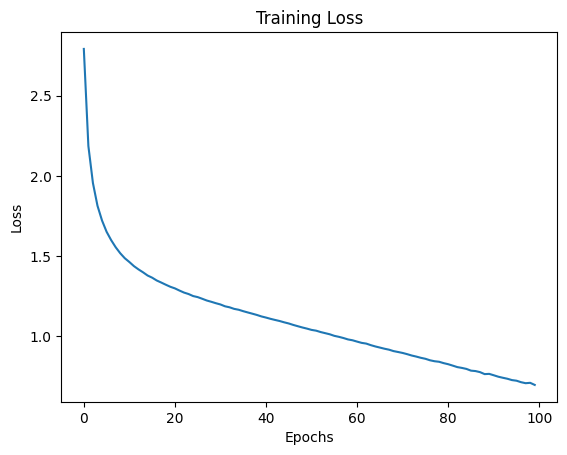

In [27]:
plt.plot(range(num_epochs), training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Lyrics generation function

In [28]:
def LyricsGenerator(starting_string, char_count, strategy='top_k', k=5, p=0.8):
    model.eval()
    generated = starting_string.strip()
    cleaned_start = clean_text(starting_string)
    input_indices = [char2idx.get(ch, 0) for ch in cleaned_start]
    
    if len(input_indices) == 0:
        random_token = np.random.choice(list(char2idx.values()))
        input_indices = [random_token]
        generated = idx2char.get(random_token, '')
    
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    
    while len(generated) < char_count:
        with torch.no_grad():
            outputs, hidden = model(input_tensor, hidden)
            
            last_logits = outputs[0, -1, :]
            probs = torch.softmax(last_logits, dim=0)
            
            if strategy == 'greedy':
                _, next_token = torch.max(probs, dim=0)
                next_token = next_token.item()
            elif strategy == 'top_k':
                topk_probs, topk_indices = torch.topk(probs, k)
                topk_probs = topk_probs / torch.sum(topk_probs)
                next_token = int(np.random.choice(topk_indices.cpu().numpy(), p=topk_probs.cpu().numpy()))
            elif strategy == 'nucleus':
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=0)
                cutoff = cumulative_probs > p
                if torch.any(cutoff):
                    cutoff_index = torch.nonzero(cutoff, as_tuple=False)[0].item()
                    filtered_probs = sorted_probs[:cutoff_index+1]
                    filtered_indices = sorted_indices[:cutoff_index+1]
                else:
                    filtered_probs = sorted_probs
                    filtered_indices = sorted_indices
                filtered_probs = filtered_probs / torch.sum(filtered_probs)
                next_token = int(np.random.choice(filtered_indices.cpu().numpy(), p=filtered_probs.cpu().numpy()))
            else:
                raise ValueError("Unknown strategy provided.")
            
            next_char = idx2char.get(next_token, '')
            generated += next_char
            next_tensor = torch.tensor([[next_token]], dtype=torch.long).to(device)
            input_tensor = torch.cat([input_tensor, next_tensor], dim=1)
    
    return generated


# Song generation

In [29]:
target_char_count = int(average_characters)

song1_start = "it’s not a silly little moment"
print("=== Song 1 Generation ===")
print("-> Top-k Sampling:")
print(LyricsGenerator(song1_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
print(LyricsGenerator(song1_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")

song2_start = "There used to be a greying tower"
print("=== Song 2 Generation ===")
print("-> Top-k Sampling:")
print(LyricsGenerator(song2_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
print(LyricsGenerator(song2_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")

song3_start = ""
print("=== Song 3 Generation ===")
print("-> Top-k Sampling:")
print(LyricsGenerator(song3_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
print(LyricsGenerator(song3_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")


=== Song 1 Generation ===
-> Top-k Sampling:
it’s not a silly little moment
so i came by your hands im singing
i was just cool inside your lips i say this is a long and you
i went are fly appetterself i could degrer
can you hear me or a whice and then we were on and we need a reach lookin foot
heart school down besides the mardless ran the stranger in your skins
twisted by a way on me back home

time glos take me down to my honey
were busted of crying on the percisal crash that were so long
as it cuts let the games begin
brending his hands arent

im the only one i lived to you on your skin
and you think you wont know
but i dont wanna be you
and it feels like im looking at home again

i just want you to go if you come from i caught like my bruirt
will you stick with me to you baby feel okay
but youre tired of solder and stopped at about you close
and i could hold my wars beautiful
and rose in my anger wont you stay in me
and i like youre all in there walking by at your sock and youll ju

In [30]:
from torchinfo import summary

dummy_input = torch.randint(0, vocab_size, (1, 128)).to(device)
summary(model, input_data=dummy_input, device=str(device))

Layer (type:depth-idx)                   Output Shape              Param #
LyricsLSTM_LM                            [1, 128, 32]              --
├─Embedding: 1-1                         [1, 128, 128]             4,096
├─LSTM: 1-2                              [1, 128, 256]             921,600
├─Linear: 1-3                            [1, 128, 32]              8,224
Total params: 933,920
Trainable params: 933,920
Non-trainable params: 0
Total mult-adds (M): 117.98
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 3.74
Estimated Total Size (MB): 4.16